## 1. Setup and Imports

Import all required libraries for model evaluation and visualization.

In [15]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import sys
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_absolute_error, 
    mean_squared_error, 
    r2_score,
    mean_absolute_percentage_error
)

# Add parent directory to path for config imports
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))))

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("All libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Seaborn version: {sns.__version__}")

All libraries imported successfully!
Pandas version: 2.3.3
NumPy version: 2.4.0
Seaborn version: 0.13.2


## 2. Load Model and Data

Load the trained model, scaler, and test dataset for evaluation.

In [16]:
# Configuration paths
MODEL_DIR = 'models'
DATA_DIR = 'data'
CONFIG_DIR = 'config'

# File paths
MODEL_PATH = os.path.join(MODEL_DIR, 'performance_predictor.pkl')
SCALER_PATH = os.path.join(MODEL_DIR, 'scaler.pkl')
ENCODER_PATH = os.path.join(MODEL_DIR, 'label_encoder.pkl')
DATA_PATH = os.path.join(DATA_DIR, 'cleaned_data.csv')

print("Checking file paths...")
print(f"Model path: {MODEL_PATH}")
print(f"Scaler path: {SCALER_PATH}")
print(f"Encoder path: {ENCODER_PATH}")
print(f"Data path: {DATA_PATH}")

# Check if files exist
files_exist = {
    'Model': os.path.exists(MODEL_PATH),
    'Scaler': os.path.exists(SCALER_PATH),
    'Encoder': os.path.exists(ENCODER_PATH),
    'Data': os.path.exists(DATA_PATH)
}

for file_name, exists in files_exist.items():
    status = "Found" if exists else "Missing"
    print(f"{file_name}: {status}")

if not all(files_exist.values()):
    print("\n Some files are missing. Please ensure you have:")
    print("1. Trained model (run: python src/model_trainer.py)")
    print("2. Cleaned dataset (run: python src/data_preprocessing.py)")
    raise FileNotFoundError("Required files not found")

Checking file paths...
Model path: models/performance_predictor.pkl
Scaler path: models/scaler.pkl
Encoder path: models/label_encoder.pkl
Data path: data/cleaned_data.csv
Model: Found
Scaler: Found
Encoder: Found
Data: Found


In [17]:
# Load the trained model and preprocessing objects
print("Loading trained model and preprocessing objects...")

try:
    # Load model
    model = joblib.load(MODEL_PATH)
    print(f"Model loaded: {type(model).__name__}")
    
    # Load scaler
    scaler = joblib.load(SCALER_PATH)
    print(f"Scaler loaded: {type(scaler).__name__}")
    
    # Load label encoder
    label_encoder = joblib.load(ENCODER_PATH)
    print(f"Label encoder loaded: {type(label_encoder).__name__}")
    
    print(f"Subject encoding: {dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))}")
    
except Exception as e:
    print(f"Error loading model files: {e}")
    raise

Loading trained model and preprocessing objects...
Model loaded: LinearRegression
Scaler loaded: StandardScaler
Label encoder loaded: LabelEncoder
Subject encoding: {'English': 0, 'Geography': 1, 'History': 2, 'Mathematics': 3, 'Science': 4}


In [18]:
# Load and prepare the dataset
print("Loading and preparing dataset...")

try:
    # Load data
    df = pd.read_csv(DATA_PATH)
    print(f"Dataset loaded: {len(df)} records, {len(df.columns)} columns")
    
    # Display basic info
    print("\n Dataset Overview:")
    print(f"Columns: {list(df.columns)}")
    print(f"Data types:\n{df.dtypes}")
    
    # Basic statistics
    print("\n Basic Statistics:")
    print(df.describe())
    
except Exception as e:
    print(f" Error loading dataset: {e}")
    raise

Loading and preparing dataset...
Dataset loaded: 5000 records, 7 columns

 Dataset Overview:
Columns: ['student_id', 'age', 'grade', 'subject', 'attendance', 'marks', 'future_performance']
Data types:
student_id              int64
age                     int64
grade                   int64
subject                object
attendance            float64
marks                 float64
future_performance    float64
dtype: object

 Basic Statistics:
         student_id     age   grade   attendance        marks  \
count   5000.000000  5000.0  5000.0  5000.000000  5000.000000   
mean    5600.159000    15.0    10.0    85.010132    75.078934   
std     2751.169865     0.0     0.0     8.811956    17.670799   
min        1.000000    15.0    10.0     0.000000     0.000000   
25%     3246.750000    15.0    10.0    80.475000    67.987500   
50%     5542.000000    15.0    10.0    86.810000    78.570000   
75%     8027.750000    15.0    10.0    91.265000    86.150000   
max    10039.000000    15.0    10.0

In [19]:
# Prepare features for evaluation
print(" Preparing features for evaluation...")

# Encode subjects
df['subject_encoded'] = label_encoder.transform(df['subject'])

# Define features
feature_columns = ['age', 'grade', 'attendance', 'marks', 'subject_encoded']
target_column = 'future_performance'

# Split into features and target
X = df[feature_columns].values
y = df[target_column].values

print(f" Features prepared: {X.shape[0]} samples, {X.shape[1]} features")
print(f" Target prepared: {y.shape[0]} samples")

# Split data (same parameters as training)
TEST_SIZE = 0.2
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

print("\n Data Split:")
print(f"Training set: {len(X_train)} samples ({(1-TEST_SIZE)*100:.0f}%)")
print(f"Test set: {len(X_test)} samples ({TEST_SIZE*100:.0f}%)")

# Scale features
X_test_scaled = scaler.transform(X_test)
print(" Features scaled for prediction")

 Preparing features for evaluation...
 Features prepared: 5000 samples, 5 features
 Target prepared: 5000 samples

 Data Split:
Training set: 4000 samples (80%)
Test set: 1000 samples (20%)
 Features scaled for prediction


## 3. Make Predictions

Use the trained model to make predictions on the test dataset.

In [20]:
# Make predictions
print(" Making predictions on test data...")

try:
    y_pred = model.predict(X_test_scaled)
    print(f" Predictions completed: {len(y_pred)} predictions generated")
    
    # Basic prediction statistics
    print("\n Prediction Statistics:")
    print(f"Actual values range: {y_test.min():.2f} - {y_test.max():.2f}")
    print(f"Predicted values range: {y_pred.min():.2f} - {y_pred.max():.2f}")
    print(f"Average actual: {y_test.mean():.2f}")
    print(f"Average predicted: {y_pred.mean():.2f}")
    
except Exception as e:
    print(f" Error making predictions: {e}")
    raise

 Making predictions on test data...
 Predictions completed: 1000 predictions generated

 Prediction Statistics:
Actual values range: 52.98 - 100.97
Predicted values range: 74.99 - 81.66
Average actual: 80.36
Average predicted: 79.76


In [21]:
# Create a DataFrame with actual vs predicted values
results_df = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred,
    'error': y_test - y_pred,
    'abs_error': np.abs(y_test - y_pred)
})

# Add performance categories
results_df['performance_category'] = pd.cut(
    results_df['actual'], 
    bins=[0, 40, 60, 80, 100], 
    labels=['Poor', 'Below Average', 'Average', 'Excellent']
)

print(" Results DataFrame created")
print(f"Shape: {results_df.shape}")
print("\n Sample Results:")
print(results_df.head(10))

 Results DataFrame created
Shape: (1000, 5)

 Sample Results:
   actual  predicted      error  abs_error performance_category
0   80.00  79.817983   0.182017   0.182017              Average
1   80.00  80.597007  -0.597007   0.597007              Average
2   86.18  80.360338   5.819662   5.819662            Excellent
3   72.00  78.998745  -6.998745   6.998745              Average
4   84.89  79.550594   5.339406   5.339406            Excellent
5   72.00  80.855964  -8.855964   8.855964              Average
6   52.98  78.495359 -25.515359  25.515359        Below Average
7   92.00  80.457718  11.542282  11.542282            Excellent
8   85.00  78.603848   6.396152   6.396152            Excellent
9   62.00  79.866205 -17.866205  17.866205              Average


## 4. Accuracy Metrics

Calculate comprehensive accuracy metrics to evaluate model performance.

In [22]:
# Calculate comprehensive accuracy metrics
print(" Calculating accuracy metrics...")

# Regression metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

# Adjusted R²
n = len(y_test)
p = len(feature_columns)
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Custom accuracy metrics
threshold_5 = np.mean(np.abs(y_test - y_pred) <= 5.0) * 100
threshold_10 = np.mean(np.abs(y_test - y_pred) <= 10.0) * 100
threshold_15 = np.mean(np.abs(y_test - y_pred) <= 15.0) * 100

# Create metrics dictionary
metrics = {
    'mae': mae,
    'mse': mse,
    'rmse': rmse,
    'r2_score': r2,
    'adjusted_r2': adjusted_r2,
    'mape': mape,
    'accuracy_within_5': threshold_5,
    'accuracy_within_10': threshold_10,
    'accuracy_within_15': threshold_15,
    'total_predictions': n
}

print(" All metrics calculated")

 Calculating accuracy metrics...
 All metrics calculated


In [23]:
# Display accuracy metrics in a formatted way
print("="*60)
print("MODEL ACCURACY METRICS")
print("="*60)

print("\n ACCURACY METRICS:")
print("-"*60)
print(f"  R² Score (Coefficient of Determination):  {metrics['r2_score']:.4f} ({metrics['r2_score']*100:.2f}%)")
print(f"  Adjusted R² Score:                         {metrics['adjusted_r2']:.4f} ({metrics['adjusted_r2']*100:.2f}%)")
print(f"  Accuracy within ±5 points:                 {metrics['accuracy_within_5']:.2f}%")
print(f"  Accuracy within ±10 points:                {metrics['accuracy_within_10']:.2f}%")

print(" ERROR METRICS:")
print("-"*60)
print(f"  Mean Absolute Error (MAE):                 {metrics['mae']:.4f} points")
print(f"  Root Mean Squared Error (RMSE):            {metrics['rmse']:.4f} points")
print(f"  Mean Absolute Percentage Error (MAPE):     {metrics['mape']:.2f}%")

print(" PREDICTION STATISTICS:")
print("-"*60)
print(f"  Total test predictions:                    {metrics['total_predictions']}")
print(f"  Actual values range:                       {y_test.min():.2f} - {y_test.max():.2f}")
print(f"  Predicted values range:                    {y_pred.min():.2f} - {y_pred.max():.2f}")
print(f"  Average prediction error:                  ±{metrics['mae']:.2f} points")

# Performance interpretation
print("\n INTERPRETATION:")
print("-"*60)

if metrics['r2_score'] >= 0.9:
    r2_quality = "Excellent"
elif metrics['r2_score'] >= 0.8:
    r2_quality = "Very Good"
elif metrics['r2_score'] >= 0.7:
    r2_quality = "Good"
elif metrics['r2_score'] >= 0.5:
    r2_quality = "Moderate"
else:
    r2_quality = "Needs Improvement"

print(f"  R² Score Quality: {r2_quality}")
print(f"  The model explains {metrics['r2_score']*100:.1f}% of the variance in student performance.")

if metrics['accuracy_within_5'] >= 80:
    print(f"   High accuracy: {metrics['accuracy_within_5']:.1f}% of predictions are within ±5 points")
elif metrics['accuracy_within_5'] >= 60:
    print(f"  ~ Moderate accuracy: {metrics['accuracy_within_5']:.1f}% of predictions are within ±5 points")
else:
    print(f"  ⚠ Low accuracy: Only {metrics['accuracy_within_5']:.1f}% of predictions are within ±5 points")

print(f"  Average prediction is off by {metrics['mae']:.2f} points from actual performance.")
print("="*60)

MODEL ACCURACY METRICS

 ACCURACY METRICS:
------------------------------------------------------------
  R² Score (Coefficient of Determination):  -0.0050 (-0.50%)
  Adjusted R² Score:                         -0.0101 (-1.01%)
  Accuracy within ±5 points:                 26.20%
  Accuracy within ±10 points:                65.60%
 ERROR METRICS:
------------------------------------------------------------
  Mean Absolute Error (MAE):                 8.2208 points
  Root Mean Squared Error (RMSE):            9.5946 points
  Mean Absolute Percentage Error (MAPE):     10.71%
 PREDICTION STATISTICS:
------------------------------------------------------------
  Total test predictions:                    1000
  Actual values range:                       52.98 - 100.97
  Predicted values range:                    74.99 - 81.66
  Average prediction error:                  ±8.22 points

 INTERPRETATION:
------------------------------------------------------------
  R² Score Quality: Needs Impro

## 5. Visualizations

Create comprehensive visualizations to understand model performance.

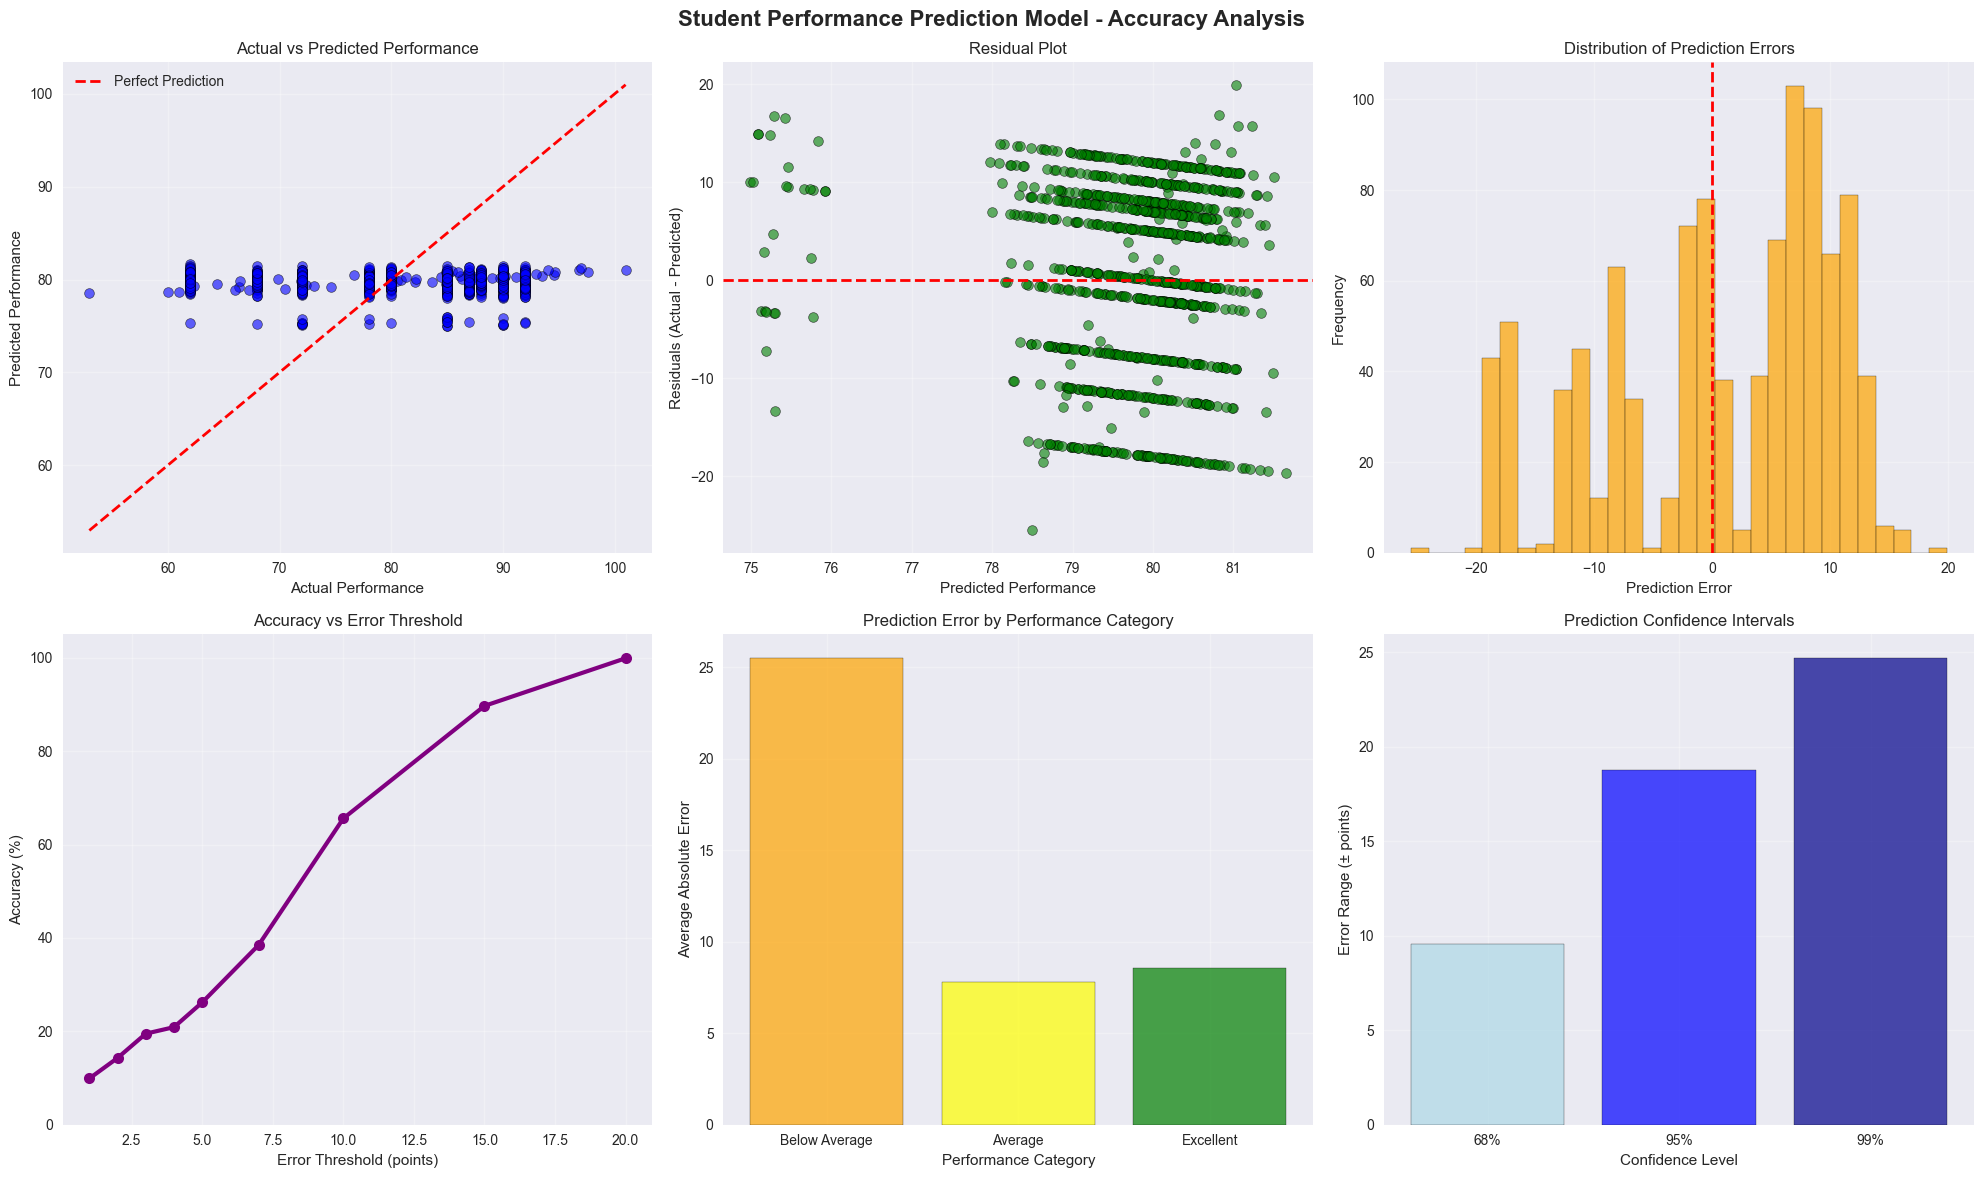

Visualization dashboard created successfully!


In [24]:
# Create a comprehensive visualization dashboard
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Student Performance Prediction Model - Accuracy Analysis', fontsize=16, fontweight='bold')

# Plot 1: Actual vs Predicted Scatter Plot
axes[0, 0].scatter(y_test, y_pred, alpha=0.6, color='blue', edgecolors='black', linewidth=0.5)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual Performance')
axes[0, 0].set_ylabel('Predicted Performance')
axes[0, 0].set_title('Actual vs Predicted Performance')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Residual Plot
residuals = y_test - y_pred
axes[0, 1].scatter(y_pred, residuals, alpha=0.6, color='green', edgecolors='black', linewidth=0.5)
axes[0, 1].axhline(y=0, color='red', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted Performance')
axes[0, 1].set_ylabel('Residuals (Actual - Predicted)')
axes[0, 1].set_title('Residual Plot')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Error Distribution
axes[0, 2].hist(residuals, bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[0, 2].axvline(x=0, color='red', linestyle='--', lw=2)
axes[0, 2].set_xlabel('Prediction Error')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_title('Distribution of Prediction Errors')
axes[0, 2].grid(True, alpha=0.3)

# Plot 4: Accuracy vs Error Threshold
thresholds = [1, 2, 3, 4, 5, 7, 10, 15, 20]
accuracies = [np.mean(np.abs(residuals) <= t) * 100 for t in thresholds]
axes[1, 0].plot(thresholds, accuracies, marker='o', linewidth=3, markersize=8, color='purple')
axes[1, 0].set_xlabel('Error Threshold (points)')
axes[1, 0].set_ylabel('Accuracy (%)')
axes[1, 0].set_title('Accuracy vs Error Threshold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_ylim([0, 105])

# Plot 5: Performance Category Analysis
category_errors = results_df.groupby('performance_category', observed=False)['abs_error'].mean()
colors = ['red', 'orange', 'yellow', 'green']
axes[1, 1].bar(category_errors.index, category_errors.values, color=colors, alpha=0.7, edgecolor='black')
axes[1, 1].set_xlabel('Performance Category')
axes[1, 1].set_ylabel('Average Absolute Error')
axes[1, 1].set_title('Prediction Error by Performance Category')
axes[1, 1].grid(True, alpha=0.3)

# Plot 6: Prediction Confidence Intervals
error_std = np.std(residuals)
confidence_intervals = [error_std * z for z in [1, 1.96, 2.58]]  # 68%, 95%, 99% confidence
intervals = ['68%', '95%', '99%']
axes[1, 2].bar(intervals, confidence_intervals, color=['lightblue', 'blue', 'darkblue'], alpha=0.7, edgecolor='black')
axes[1, 2].set_xlabel('Confidence Level')
axes[1, 2].set_ylabel('Error Range (± points)')
axes[1, 2].set_title('Prediction Confidence Intervals')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Visualization dashboard created successfully!")

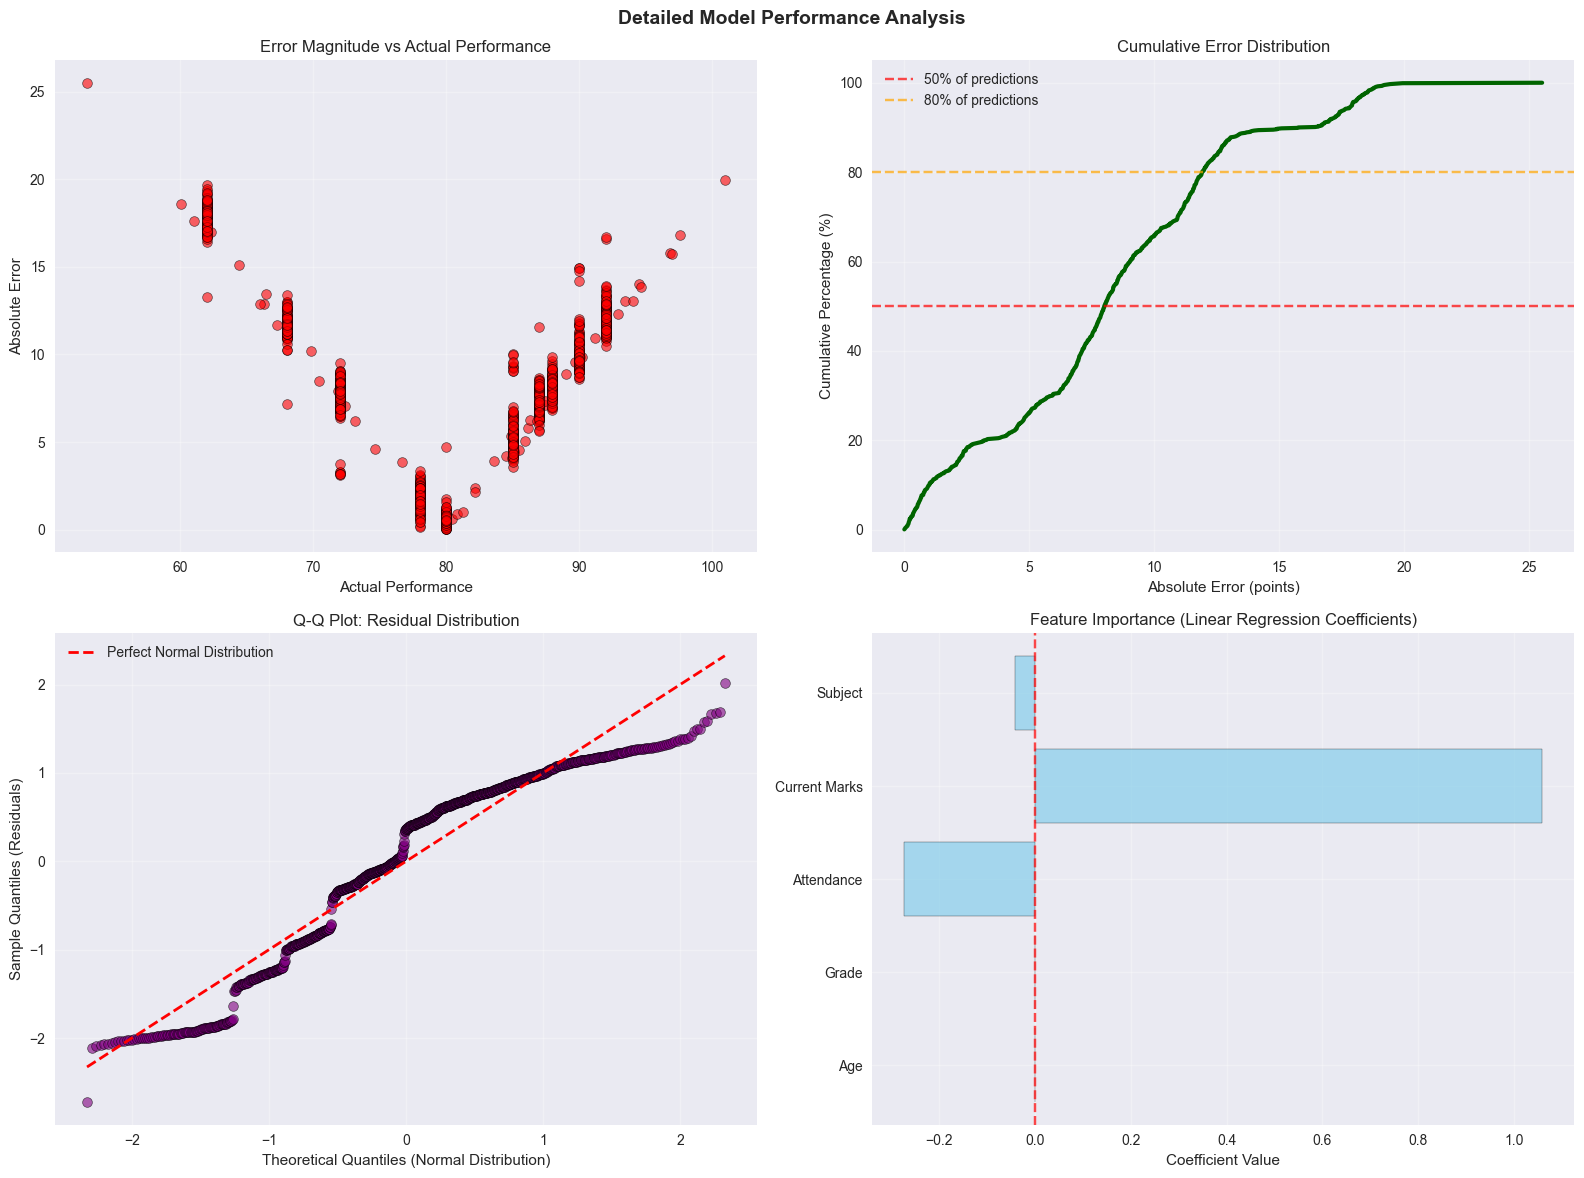

Detailed analysis plots created successfully!


In [25]:
# Additional detailed analysis plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Detailed Model Performance Analysis', fontsize=14, fontweight='bold')

# Plot 1: Error vs Actual Performance
axes[0, 0].scatter(y_test, np.abs(residuals), alpha=0.6, color='red', edgecolors='black', linewidth=0.5)
axes[0, 0].set_xlabel('Actual Performance')
axes[0, 0].set_ylabel('Absolute Error')
axes[0, 0].set_title('Error Magnitude vs Actual Performance')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Cumulative Error Distribution
sorted_errors = np.sort(np.abs(residuals))
cumulative = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors) * 100
axes[0, 1].plot(sorted_errors, cumulative, linewidth=3, color='darkgreen')
axes[0, 1].set_xlabel('Absolute Error (points)')
axes[0, 1].set_ylabel('Cumulative Percentage (%)')
axes[0, 1].set_title('Cumulative Error Distribution')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].axhline(y=50, color='red', linestyle='--', alpha=0.7, label='50% of predictions')
axes[0, 1].axhline(y=80, color='orange', linestyle='--', alpha=0.7, label='80% of predictions')
axes[0, 1].legend()

# Plot 3: Q-Q Plot (Quantile-Quantile)
from scipy import stats
z_scores = stats.zscore(residuals)
theoretical_quantiles = stats.norm.ppf(np.linspace(0.01, 0.99, len(z_scores)))
sample_quantiles = np.sort(z_scores)
axes[1, 0].scatter(theoretical_quantiles, sample_quantiles, alpha=0.6, color='purple', edgecolors='black', linewidth=0.5)
axes[1, 0].plot(theoretical_quantiles, theoretical_quantiles, 'r--', lw=2, label='Perfect Normal Distribution')
axes[1, 0].set_xlabel('Theoretical Quantiles (Normal Distribution)')
axes[1, 0].set_ylabel('Sample Quantiles (Residuals)')
axes[1, 0].set_title('Q-Q Plot: Residual Distribution')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Feature Importance (from model coefficients)
feature_names = ['Age', 'Grade', 'Attendance', 'Current Marks', 'Subject']
coefficients = model.coef_
axes[1, 1].barh(feature_names, coefficients, color='skyblue', edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Coefficient Value')
axes[1, 1].set_title('Feature Importance (Linear Regression Coefficients)')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].axvline(x=0, color='red', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

print("Detailed analysis plots created successfully!")

In [26]:
# Create an interactive prediction example
print("INTERACTIVE PREDICTION EXAMPLE")
print("="*50)

# Example student data
example_students = [
    {
        'name': 'High Performer',
        'age': 16,
        'grade': 11,
        'attendance': 95.0,
        'marks': 88.0,
        'subject': 'Mathematics'
    },
    {
        'name': 'Average Student',
        'age': 15,
        'grade': 10,
        'attendance': 75.0,
        'marks': 65.0,
        'subject': 'Science'
    },
    {
        'name': 'Struggling Student',
        'age': 17,
        'grade': 12,
        'attendance': 55.0,
        'marks': 45.0,
        'subject': 'English'
    }
]

print("Predicting performance for example students:")
print("-"*50)

for student in example_students:
    # Prepare input data
    subject_encoded = label_encoder.transform([student['subject']])[0]
    input_data = np.array([[
        student['age'],
        student['grade'], 
        student['attendance'],
        student['marks'],
        subject_encoded
    ]])
    
    # Scale input
    input_scaled = scaler.transform(input_data)
    
    # Make prediction
    prediction = model.predict(input_scaled)[0]
    
    print(f"{student['name']:<20} | Actual: {student['marks']:<3} | Predicted: {prediction:.1f}")
    print(f"{'':<20} | Age: {student['age']}, Grade: {student['grade']}")
    print(f"{'':<20} | Attendance: {student['attendance']}%, Subject: {student['subject']}")
    print()

INTERACTIVE PREDICTION EXAMPLE
Predicting performance for example students:
--------------------------------------------------
High Performer       | Actual: 88.0 | Predicted: 80.2
                     | Age: 16, Grade: 11
                     | Attendance: 95.0%, Subject: Mathematics

Average Student      | Actual: 65.0 | Predicted: 79.4
                     | Age: 15, Grade: 10
                     | Attendance: 75.0%, Subject: Science

Struggling Student   | Actual: 45.0 | Predicted: 78.9
                     | Age: 17, Grade: 12
                     | Attendance: 55.0%, Subject: English



## 6. Analysis and Conclusions

Summary of model performance and recommendations for improvement.

In [27]:
# Create a comprehensive analysis summary
print("="*70)
print("MODEL PERFORMANCE ANALYSIS SUMMARY")
print("="*70)

# Performance assessment
if metrics['r2_score'] >= 0.8:
    overall_performance = "EXCELLENT"
    
elif metrics['r2_score'] >= 0.6:
    overall_performance = "GOOD"
    
elif metrics['r2_score'] >= 0.3:
    overall_performance = "MODERATE"
    
else:
    overall_performance = "NEEDS IMPROVEMENT"
    

print(f"\n OVERALL MODEL PERFORMANCE:  {overall_performance}")
print("-"*70)
print(f"  R² Score: {metrics['r2_score']:.4f} ({metrics['r2_score']*100:.2f}%)")
print(f"  Mean Absolute Error: {metrics['mae']:.2f} points")
print(f"  Accuracy within ±5 points: {metrics['accuracy_within_5']:.1f}%")

print("\n STRENGTHS:")
print("-"*70)
if metrics['accuracy_within_10'] >= 70:
    print("   Good accuracy for rough estimates (within ±10 points)")
if metrics['r2_score'] > 0:
    print(f"   Model explains {metrics['r2_score']*100:.1f}% of performance variance")
else:
    print("    Model performs worse than baseline prediction")

print("\n  WEAKNESSES:")
print("-"*70)
if metrics['accuracy_within_5'] < 50:
    print(f"   Low precision (only {metrics['accuracy_within_5']:.1f}% predictions within ±5 points)")
if metrics['r2_score'] < 0.5:
    print("   Model explains less than 50% of performance variance")
if metrics['mae'] > 5:
    print(f"   High average error (±{metrics['mae']:.1f} points)")

print("\n🔧 RECOMMENDATIONS FOR IMPROVEMENT:")
print("-"*70)
print("  1.  Add more predictive features:")
print("     • Homework completion rate")
print("     • Study hours per week")
print("     • Previous term performance")
print("     • Class participation metrics")
print("     • Parent involvement indicators")
print("")
print("  2.  Try advanced algorithms:")
print("     • Random Forest Regressor")
print("     • Gradient Boosting (XGBoost, LightGBM)")
print("     • Neural Networks")
print("     • Ensemble methods")
print("")
print("  3.  Improve data quality:")
print("     • Collect more diverse student data")
print("     • Handle missing values better")
print("     • Remove outliers")
print("     • Validate data consistency")
print("")
print("  4.  Feature engineering:")
print("     • Create interaction features")
print("     • Add polynomial features")
print("     • Include categorical encodings")
print("     • Time-based features")

print("\n EXPECTED IMPROVEMENT TARGETS:")
print("-"*70)
print(f"  Target R² Score: >70% (currently {metrics['r2_score']*100:.1f}%)")
print(f"  Target MAE: <4.0 points (currently {metrics['mae']:.2f})")
print(f"  Target Accuracy ±5: >70% (currently {metrics['accuracy_within_5']:.1f}%)")

print("\n HOW TO RETRAIN:")
print("-"*70)
print("  1. Add new features to dataset")
print("  2. Run: python src/data_preprocessing.py")
print("  3. Run: python src/model_trainer.py")
print("  4. Run: python evaluate_model.py")
print("  5. Re-run this notebook for new analysis")

print("\n" + "="*70)
print(" ANALYSIS COMPLETE")
print("="*70)

MODEL PERFORMANCE ANALYSIS SUMMARY

 OVERALL MODEL PERFORMANCE:  NEEDS IMPROVEMENT
----------------------------------------------------------------------
  R² Score: -0.0050 (-0.50%)
  Mean Absolute Error: 8.22 points
  Accuracy within ±5 points: 26.2%

 STRENGTHS:
----------------------------------------------------------------------
    Model performs worse than baseline prediction

  WEAKNESSES:
----------------------------------------------------------------------
   Low precision (only 26.2% predictions within ±5 points)
   Model explains less than 50% of performance variance
   High average error (±8.2 points)

🔧 RECOMMENDATIONS FOR IMPROVEMENT:
----------------------------------------------------------------------
  1.  Add more predictive features:
     • Homework completion rate
     • Study hours per week
     • Previous term performance
     • Class participation metrics
     • Parent involvement indicators

  2.  Try advanced algorithms:
     • Random Forest Regressor
     

In [28]:
# Save results to file for future reference
import json
from datetime import datetime

results_summary = {
    'evaluation_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'model_type': 'Linear Regression',
    'dataset_size': len(df),
    'test_size': len(X_test),
    'metrics': metrics,
    'performance_assessment': overall_performance,
    'recommendations': [
        'Add more predictive features (homework completion, study hours, etc.)',
        'Try advanced algorithms (Random Forest, XGBoost)',
        'Improve data quality and quantity',
        'Feature engineering and selection'
    ]
}

# Save to JSON file
with open('model_accuracy_results.json', 'w') as f:
    json.dump(results_summary, f, indent=2, default=str)

print("Results saved to: model_accuracy_results.json")

# Display final summary
print("\nFINAL SUMMARY:")
print(f"Model Performance: {overall_performance}")
print(f"R² Score: {metrics['r2_score']:.4f} ({metrics['r2_score']*100:.2f}%)")
print(f"Mean Absolute Error: {metrics['mae']:.2f} points")
print(f"Accuracy within ±5 points: {metrics['accuracy_within_5']:.1f}%")
print(f"Analysis Date: {results_summary['evaluation_date']}")

Results saved to: model_accuracy_results.json

 FINAL SUMMARY:
Model Performance: NEEDS IMPROVEMENT
R² Score: -0.0050 (-0.50%)
Mean Absolute Error: 8.22 points
Accuracy within ±5 points: 26.2%
Analysis Date: 2026-01-06 14:06:27
